In [53]:
# ─────────────────────────────────────────────────────────────────────────────
# 1. LOAD RAW TRANSACTIONS
# ─────────────────────────────────────────────────────────────────────────────
df = spark.sql("""
    SELECT *
    FROM Machine_Learning.filtered_data.all_year_fact_sales
""")


StatementMeta(, 62f43b20-8ff0-4873-819f-ddeeefb83137, 55, Finished, Available, Finished)

In [54]:
dim_stores = spark.sql("SELECT store_key , CAST(store_size as INTEGER) FROM Gold_Data.dim_stores.dim_stores")

StatementMeta(, 62f43b20-8ff0-4873-819f-ddeeefb83137, 56, Finished, Available, Finished)

In [55]:
# ─────────────────────────────────────────────────────────────────────────────
# 3. BASIC CLEAN-UPS 
# ─────────────────────────────────────────────────────────────────────────────
from pyspark.sql import functions as F

df = (
    df
    # make sure booleans & numerics are nicely typed
    .withColumn("is_promo",    F.col("is_promotion_active").cast("int"))
    .withColumn("quantities_sold", F.col("quantities_sold").cast("double"))
    .withColumn("revenue",         F.col("revenue").cast("double"))
    .withColumn("price",           F.col("price").cast("double"))
    .withColumn("stock_quantity",  F.col("stock_quantity").cast("double"))
    # convert  yyyymmdd → date
    .withColumn("date", F.to_date(F.col("date_id").cast("string"), "yyyyMMdd"))
)


StatementMeta(, 62f43b20-8ff0-4873-819f-ddeeefb83137, 57, Finished, Available, Finished)

In [56]:
# ─────────────────────────────────────────────────────────────────────────────
# 4. FEATURE ENGINEERING  (aggregate to store level, then JOIN size)
# ─────────────────────────────────────────────────────────────────────────────
store_feats = (
    df.groupBy("store_key")
      .agg(
          F.sum("revenue").alias("total_revenue"),
          F.sum("quantities_sold").alias("total_qty"),
          F.countDistinct("product_key").alias("n_distinct_products"),
          F.avg("price").alias("avg_unit_price"),
          F.avg("stock_quantity").alias("avg_stock"),
          F.avg("is_promo").alias("pct_days_with_promo"),
          F.sum(F.when(F.col("is_promo") == 1, F.col("revenue")).otherwise(0)).alias("revenue_under_promo"),
          F.countDistinct("date").alias("active_days")
      )
      .withColumn("revenue_per_day",     F.col("total_revenue") / F.col("active_days"))
      .withColumn("promo_revenue_ratio", F.col("revenue_under_promo") / F.col("total_revenue"))
      .fillna({"promo_revenue_ratio": 0.0})
)

StatementMeta(, 62f43b20-8ff0-4873-819f-ddeeefb83137, 58, Finished, Available, Finished)

In [57]:
# ─────────────────────────────────────────────────────────────────────────────
# 5.  BRING IN STORE SIZE
# ─────────────────────────────────────────────────────────────────────────────
store_feats = store_feats.join(dim_stores, on="store_key", how="left")

StatementMeta(, 62f43b20-8ff0-4873-819f-ddeeefb83137, 59, Finished, Available, Finished)

In [58]:
# ─────────────────────────────────────────────────────────────────────────────
# 6. ASSEMBLE FEATURES & STANDARDISE
# ─────────────────────────────────────────────────────────────────────────────
from pyspark.ml.feature import VectorAssembler, StandardScaler

num_cols = [
    "total_revenue",
    "total_qty",
    "revenue_per_day",
    "store_size"
]

assembler = VectorAssembler(inputCols=num_cols, outputCol="raw_features")
scaler    = StandardScaler(inputCol="raw_features",
                           outputCol="scaled_features",
                           withStd=True,
                           withMean=True)

assembled  = assembler.transform(store_feats)
scaled     = scaler.fit(assembled).transform(assembled)

StatementMeta(, 62f43b20-8ff0-4873-819f-ddeeefb83137, 60, Finished, Available, Finished)

In [59]:
# ─────────────────────────────────────────────────────────────────────────────
# 7. K-MEANS CLUSTERING
# ─────────────────────────────────────────────────────────────────────────────
from pyspark.ml.clustering import KMeans

k        = 4                                    
seed     = 42
kmeans   = KMeans(featuresCol="scaled_features",
                  predictionCol="store_cluster",
                  k=k,
                  seed=seed)

model     = kmeans.fit(scaled)
clusters  = model.transform(scaled)

StatementMeta(, 62f43b20-8ff0-4873-819f-ddeeefb83137, 61, Finished, Available, Finished)

In [60]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(
    featuresCol="scaled_features",
    predictionCol="store_cluster",      
    metricName="silhouette",
    distanceMeasure="squaredEuclidean"
)

silhouette = evaluator.evaluate(clusters)
print(f"Silhouette score with k={k}: {silhouette:.3f}")


StatementMeta(, 62f43b20-8ff0-4873-819f-ddeeefb83137, 62, Finished, Available, Finished)

Silhouette score with k=4: 0.733


In [61]:
clusters.select("store_key", "store_cluster").show()

StatementMeta(, 62f43b20-8ff0-4873-819f-ddeeefb83137, 63, Finished, Available, Finished)

+---------+-------------+
|store_key|store_cluster|
+---------+-------------+
|       31|            0|
|       53|            2|
|       34|            2|
|       28|            0|
|       26|            2|
|       27|            0|
|       44|            0|
|       12|            2|
|       22|            0|
|       47|            3|
|        1|            2|
|       52|            0|
|       13|            3|
|       16|            0|
|        6|            0|
|        3|            0|
|       40|            1|
|       20|            0|
|       57|            2|
|       54|            0|
+---------+-------------+
only showing top 20 rows



In [66]:
(
    clusters
    .select("store_key", "store_cluster")  
    .write
    .saveAsTable("Machine_Learning.filtered_data.store_clusters_kmeans")
)

print("✅ Done - clusters written to Machine_Learning.model_output.store_clusters_kmeans")

StatementMeta(, 62f43b20-8ff0-4873-819f-ddeeefb83137, 68, Finished, Available, Finished)

✅ Done - clusters written to Machine_Learning.model_output.store_clusters_kmeans


In [62]:
# # ─────────────────────────────────────────────────────────────────────────────
# # 6. PERSIST RESULTS
# # ─────────────────────────────────────────────────────────────────────────────
# (
#     clusters
#     .select("store_key", "store_cluster", *num_cols)   # keep interpretable columns
#     .write
#     .mode("overwrite")
#     .saveAsTable("Machine_Learning.model_output.store_clusters_kmeans")
# )

# print("✅ Done – clusters written to Machine_Learning.model_output.store_clusters_kmeans")


StatementMeta(, 62f43b20-8ff0-4873-819f-ddeeefb83137, 64, Finished, Available, Finished)

## Cluster Analysis 

Uncomment to check

In [63]:
# # ─────────────────────────────────────────────────────────────────────────────
# # A)  HOW MANY STORES PER CLUSTER + BASIC PROFILES
# # ─────────────────────────────────────────────────────────────────────────────
# from pyspark.sql import functions as F

# profile = (
#     clusters
#       .groupBy("store_cluster")
#       .agg(
#           F.count("*").alias("n_stores"),
#           *[F.round(F.avg(c), 2).alias(f"avg_{c}") for c in num_cols]
#       )
#       .orderBy("store_cluster")
# )

# print(f"\n===== Cluster snapshot  (k = {k}) =====")
# profile.show(truncate=False)

StatementMeta(, 62f43b20-8ff0-4873-819f-ddeeefb83137, 65, Finished, Available, Finished)


===== Cluster snapshot  (k = 4) =====
+-------------+--------+-----------------+-------------+-------------------+--------------+
|store_cluster|n_stores|avg_total_revenue|avg_total_qty|avg_revenue_per_day|avg_store_size|
+-------------+--------+-----------------+-------------+-------------------+--------------+
|0            |43      |150261.49        |31307.92     |162.86             |18.0          |
|1            |1       |2487297.09       |421882.97    |2407.84            |60.0          |
|2            |12      |509006.53        |85529.67     |511.8              |36.75         |
|3            |6       |1398949.0        |210305.89    |1354.26            |46.0          |
+-------------+--------+-----------------+-------------+-------------------+--------------+



In [64]:
# # ─────────────────────────────────────────────────────────────────────────────
# # B)  WHICH FEATURES DRIVE THE SEGMENTATION?
# #     We'll take the (scaled) centroid matrix and compute the
# #     *range* across clusters for each feature as a proxy importance score.
# # ─────────────────────────────────────────────────────────────────────────────
# import pandas as pd

# centers = pd.DataFrame(model.clusterCenters(), columns=num_cols)  # k × d
# importance = (centers.max() - centers.min()).abs().sort_values(ascending=False)

# print("\n===== Feature importance (simple centroid range) =====")
# display(
#     pd.DataFrame({
#         "feature": importance.index,
#         "range_across_clusters": importance.values
#     })
# )

StatementMeta(, 62f43b20-8ff0-4873-819f-ddeeefb83137, 66, Finished, Available, Finished)


===== Feature importance (simple centroid range) =====


SynapseWidget(Synapse.DataFrame, 4af48ba4-fc57-4d2b-9046-95bcf05ddbfb)

StatementMeta(, 62f43b20-8ff0-4873-819f-ddeeefb83137, 67, Finished, Available, Finished)

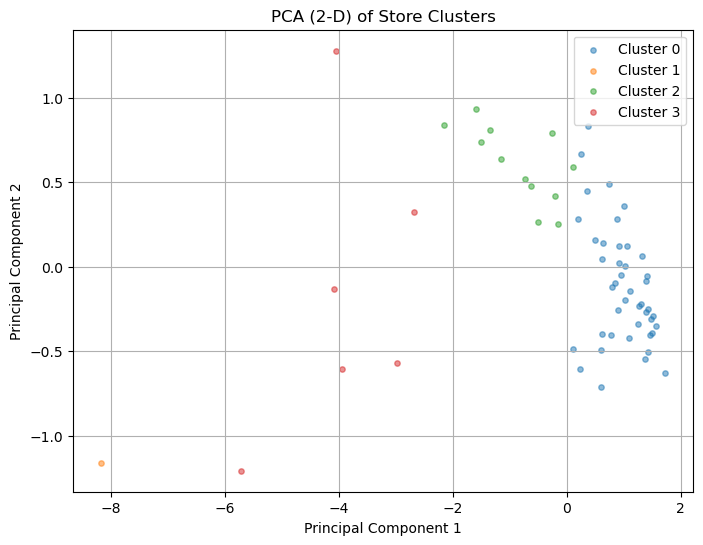

In [65]:
# # ─────────────────────────────────────────────────────────────────────────────
# # C)  VISUALISE CLUSTERS IN 2-D WITH PCA
# # ─────────────────────────────────────────────────────────────────────────────
# from pyspark.ml.feature import PCA

# # 1. Fit PCA to the *scaled* feature vector
# pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_vec")
# pca_model = pca.fit(clusters)
# pca_df = pca_model.transform(clusters).select("store_cluster", "pca_vec")

# # 2. Collect a manageable sample (or all rows if small) to the driver
# SAMPLE_SIZE = 5000   # tweak for your cluster size
# pandas_pca = (
#     pca_df
#       .limit(SAMPLE_SIZE)            # comment out if dataset is tiny
#       .toPandas()
# )

# # 3. Split the vector column into x / y for plotting
# pandas_pca["pc1"] = pandas_pca["pca_vec"].apply(lambda v: float(v[0]))
# pandas_pca["pc2"] = pandas_pca["pca_vec"].apply(lambda v: float(v[1]))

# # 4. Plot
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 6))
# for cl in sorted(pandas_pca.store_cluster.unique()):
#     subset = pandas_pca[pandas_pca.store_cluster == cl]
#     plt.scatter(subset.pc1, subset.pc2, label=f"Cluster {cl}", alpha=0.5, s=15)

# plt.title("PCA (2-D) of Store Clusters")
# plt.xlabel("Principal Component 1")
# plt.ylabel("Principal Component 2")
# plt.legend()
# plt.grid(True)
# plt.show()

StatementMeta(, 223e311c-7746-4c8e-904a-a1a01a967188, 4, Finished, Available, Finished)

Cluster Centroids (Normalized Values):
   total_revenue  total_qty  revenue_per_day  store_size  cluster
0      -0.471270  -0.452240        -0.473620   -0.556530        0
1       4.359969   4.725123         4.380535    2.774976        1
2       0.270346   0.266510         0.280867    0.930749        2
3       2.110080   1.920512         2.102455    1.664474        3


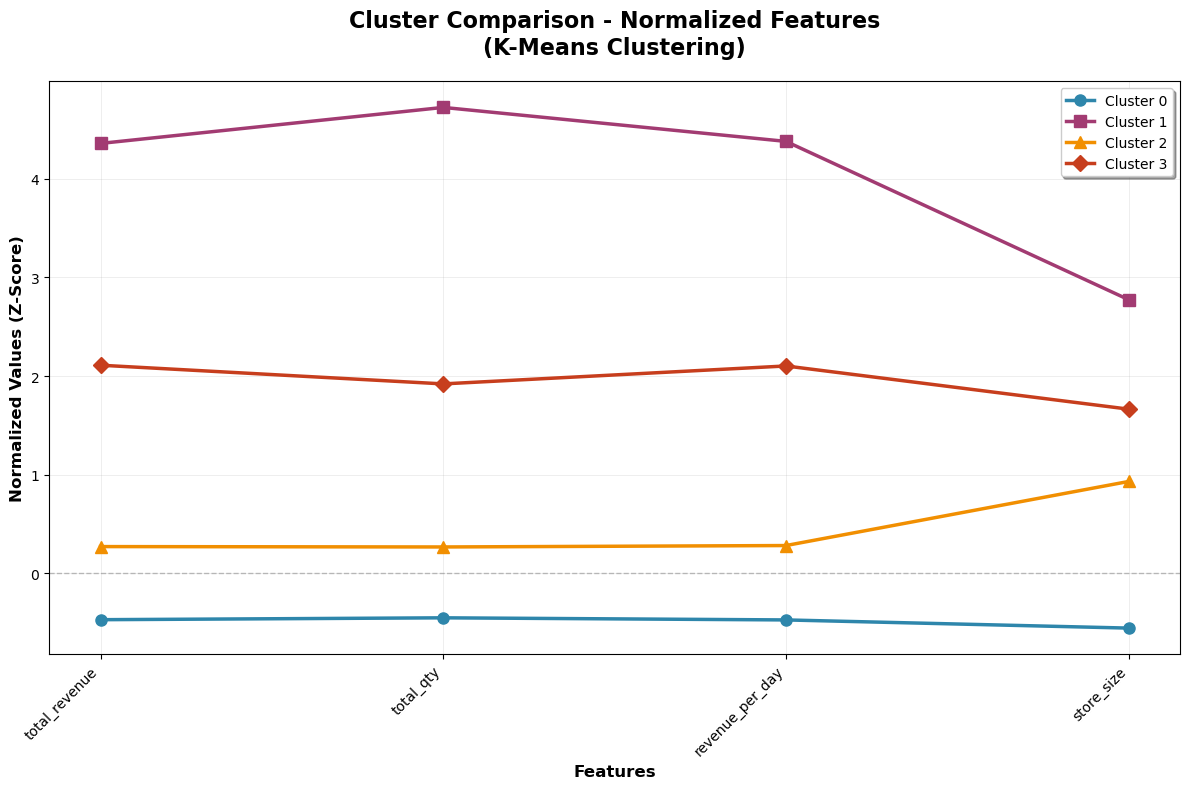


CLUSTER INTERPRETATION (Normalized Values)

🏪 CLUSTER 0:
   📊 total_revenue: -0.47 (MEDIUM)
   📊 total_qty: -0.45 (MEDIUM)
   📊 revenue_per_day: -0.47 (MEDIUM)
   📊 store_size: -0.56 (LOW)

🏪 CLUSTER 1:
   📊 total_revenue: 4.36 (HIGH)
   📊 total_qty: 4.73 (HIGH)
   📊 revenue_per_day: 4.38 (HIGH)
   📊 store_size: 2.77 (HIGH)

🏪 CLUSTER 2:
   📊 total_revenue: 0.27 (MEDIUM)
   📊 total_qty: 0.27 (MEDIUM)
   📊 revenue_per_day: 0.28 (MEDIUM)
   📊 store_size: 0.93 (HIGH)

🏪 CLUSTER 3:
   📊 total_revenue: 2.11 (HIGH)
   📊 total_qty: 1.92 (HIGH)
   📊 revenue_per_day: 2.10 (HIGH)
   📊 store_size: 1.66 (HIGH)

💡 Values > 0.5: Above average
💡 Values -0.5 to 0.5: Around average
💡 Values < -0.5: Below average


In [2]:
# ─────────────────────────────────────────────────────────────────────────────
# LINE GRAPH FOR CLUSTER FEATURES COMPARISON (NORMALIZED FEATURES)
# ─────────────────────────────────────────────────────────────────────────────

import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans

# ─────────────────────────────────────────────────────────────────────────────
# 1. RECREATE THE DATA PIPELINE (CONDENSED VERSION)
# ─────────────────────────────────────────────────────────────────────────────

# Load data
df = spark.sql("SELECT * FROM Machine_Learning.filtered_data.all_year_fact_sales")
dim_stores = spark.sql("SELECT store_key , CAST(store_size as INTEGER) FROM Gold_Data.dim_stores.dim_stores")

# Basic cleanup
df = (df
    .withColumn("is_promo", F.col("is_promotion_active").cast("int"))
    .withColumn("quantities_sold", F.col("quantities_sold").cast("double"))
    .withColumn("revenue", F.col("revenue").cast("double"))
    .withColumn("price", F.col("price").cast("double"))
    .withColumn("stock_quantity", F.col("stock_quantity").cast("double"))
    .withColumn("date", F.to_date(F.col("date_id").cast("string"), "yyyyMMdd"))
)

# Feature engineering
store_feats = (df.groupBy("store_key")
    .agg(
        F.sum("revenue").alias("total_revenue"),
        F.sum("quantities_sold").alias("total_qty"),
        F.countDistinct("product_key").alias("n_distinct_products"),
        F.avg("price").alias("avg_unit_price"),
        F.avg("stock_quantity").alias("avg_stock"),
        F.avg("is_promo").alias("pct_days_with_promo"),
        F.sum(F.when(F.col("is_promo") == 1, F.col("revenue")).otherwise(0)).alias("revenue_under_promo"),
        F.countDistinct("date").alias("active_days")
    )
    .withColumn("revenue_per_day", F.col("total_revenue") / F.col("active_days"))
    .withColumn("promo_revenue_ratio", F.col("revenue_under_promo") / F.col("total_revenue"))
    .fillna({"promo_revenue_ratio": 0.0})
)

# Join with store size
store_feats = store_feats.join(dim_stores, on="store_key", how="left")

# Assemble and scale features
feature_names = ["total_revenue", "total_qty", "revenue_per_day", "store_size"]
assembler = VectorAssembler(inputCols=feature_names, outputCol="raw_features")
scaler = StandardScaler(inputCol="raw_features", outputCol="scaled_features", withStd=True, withMean=True)
assembled = assembler.transform(store_feats)
scaler_model = scaler.fit(assembled)
scaled = scaler_model.transform(assembled)

# ─────────────────────────────────────────────────────────────────────────────
# 2. APPLY K-MEANS CLUSTERING
# ─────────────────────────────────────────────────────────────────────────────

k = 4
kmeans = KMeans(featuresCol="scaled_features", predictionCol="store_cluster", k=k, seed=42)
model = kmeans.fit(scaled)
clusters = model.transform(scaled)

# ─────────────────────────────────────────────────────────────────────────────
# 3. EXTRACT CLUSTER CENTROIDS
# ─────────────────────────────────────────────────────────────────────────────

# Get the centroids (normalized feature values) for each cluster
centroids = model.clusterCenters()

# Convert to pandas DataFrame for easier plotting
centroids_df = pd.DataFrame(centroids, columns=feature_names)
centroids_df['cluster'] = range(k)

print("Cluster Centroids (Normalized Values):")
print(centroids_df)

# ─────────────────────────────────────────────────────────────────────────────
# 2. CREATE LINE GRAPH
# ─────────────────────────────────────────────────────────────────────────────

plt.figure(figsize=(12, 8))

# Define colors and markers for each cluster
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
markers = ['o', 's', '^', 'D']

# Plot line for each cluster
for i in range(k):
    cluster_values = centroids_df.iloc[i][feature_names].values
    
    plt.plot(feature_names, cluster_values, 
             color=colors[i], 
             marker=markers[i], 
             linewidth=2.5, 
             markersize=8,
             label=f'Cluster {i}')

# ─────────────────────────────────────────────────────────────────────────────
# 3. CUSTOMIZE THE PLOT
# ─────────────────────────────────────────────────────────────────────────────

plt.title('Cluster Comparison - Normalized Features\n(K-Means Clustering)', 
          fontsize=16, fontweight='bold', pad=20)

plt.xlabel('Features', fontsize=12, fontweight='bold')
plt.ylabel('Normalized Values (Z-Score)', fontsize=12, fontweight='bold')

# Add horizontal line at zero for reference
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, linewidth=1)

# Customize grid
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Add legend
plt.legend(frameon=True, shadow=True, loc='upper right')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# ─────────────────────────────────────────────────────────────────────────────
# 4. DISPLAY PLOT
# ─────────────────────────────────────────────────────────────────────────────

plt.show()

# ─────────────────────────────────────────────────────────────────────────────
# 5. OPTIONAL: SAVE THE PLOT
# ─────────────────────────────────────────────────────────────────────────────

# Uncomment to save the plot
# plt.savefig('cluster_features_comparison.png', dpi=300, bbox_inches='tight')

# ─────────────────────────────────────────────────────────────────────────────
# 6. PRINT CLUSTER INTERPRETATION
# ─────────────────────────────────────────────────────────────────────────────

print("\n" + "="*60)
print("CLUSTER INTERPRETATION (Normalized Values)")
print("="*60)

for i in range(k):
    print(f"\n🏪 CLUSTER {i}:")
    cluster_data = centroids_df.iloc[i]
    
    for feature in feature_names:
        value = cluster_data[feature]
        if value > 0.5:
            level = "HIGH"
        elif value > -0.5:
            level = "MEDIUM"
        else:
            level = "LOW"
        print(f"   📊 {feature}: {value:.2f} ({level})")

print("\n💡 Values > 0.5: Above average")
print("💡 Values -0.5 to 0.5: Around average") 
print("💡 Values < -0.5: Below average")